In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from tensorflow.keras.preprocessing.image import load_img
import seaborn as sns
warnings.filterwarnings('ignore')

In [3]:
input_path = []
label = []

for class_name in os.listdir('PetImages'):
    for path in os.listdir('PetImages/' + class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))

print(input_path[0], label[0])

PetImages\Cat\0.jpg 0


In [4]:
print(len(label), len(input_path))


25002 25002


In [5]:
data = pd.DataFrame(
    {"Images": input_path,
    "Label" : label}
     )

In [6]:
data.head()

,Images,Label
0,PetImages\Cat\0.jpg,0
1,PetImages\Cat\1.jpg,0
2,PetImages\Cat\10.jpg,0
3,PetImages\Cat\100.jpg,0
4,PetImages\Cat\1000.jpg,0


In [7]:
for i in data["Images"]:
    if '.jpg' not in i:
        print(i)

PetImages\Cat\Thumbs.db
PetImages\Dog\Thumbs.db


In [8]:
import PIL
k = []

for image in data['Images']:
    try:
        img = PIL.Image.open(image)
    except:
        k.append(image)

k

['PetImages\\Cat\\666.jpg',
 'PetImages\\Cat\\Thumbs.db',
 'PetImages\\Dog\\11702.jpg',
 'PetImages\\Dog\\Thumbs.db']

In [9]:
data = data[data['Images'] != 'PetImages\Dog\Thumbs.db']
data = data[data['Images'] != 'PetImages\Cat\Thumbs.db']
data = data[data['Images'] != 'PetImages\\Cat\\666.jpg']
data = data[data['Images'] != 'PetImages\\Dog\\11702.jpg']

len(data)

24998

In [10]:
data = data.sample(frac = 1).reset_index(drop = True)

data.head()

,Images,Label
0,PetImages\Dog\3531.jpg,1
1,PetImages\Dog\5171.jpg,1
2,PetImages\Dog\8090.jpg,1
3,PetImages\Dog\4798.jpg,1
4,PetImages\Dog\9780.jpg,1


In [11]:
data["Label"] = data["Label"].astype('str')

In [12]:
plt.figure(figsize=(25,25))
woof = data[data['Label']==1]['Images']
start = random.randint(0, len(woof))
files = woof[start:start + 25]

for index, file in enumerate(files):
    plt.subplot(5,5, index + 1)
    img = np.array(load_img(file))
    plt.imshow(img)
    plt.title("Dogs: ")
    plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [13]:
plt.figure(figsize=(25,25))
meow = data[data['Label']==0]['Images']
start = random.randint(0, len(meow))
files = meow[start:start + 25]

for index, file in enumerate(files):
    plt.subplot(5,5, index + 1)
    img = np.array(load_img(file))
    plt.imshow(img)
    plt.title("Cats: ")
    plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [14]:
data['Label'].value_counts()

Label
1    12499
0    12499
Name: count, dtype: int64

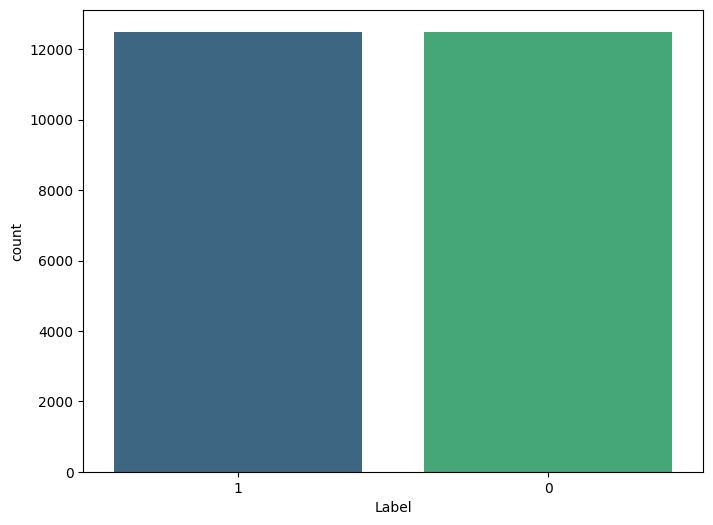

In [15]:
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.countplot(data=data, x="Label", palette="viridis", ax=ax) 

plt.show()

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

In [17]:
train.head()

,Images,Label
23286,PetImages\Cat\11007.jpg,0
17781,PetImages\Cat\242.jpg,0
1020,PetImages\Cat\5455.jpg,0
12644,PetImages\Cat\10722.jpg,0
1533,PetImages\Cat\7788.jpg,0


In [18]:
test.head()

,Images,Label
6868,PetImages\Cat\11117.jpg,0
22910,PetImages\Cat\7159.jpg,0
9668,PetImages\Cat\4892.jpg,0
13638,PetImages\Cat\1225.jpg,0
23337,PetImages\Cat\1346.jpg,0


In [19]:
test.count()

Images    5000
Label     5000
dtype: int64

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization
    rotation_range = 40,  # augmentation
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(train, x_col='Images', y_col='Label', 
                                                     target_size=(128, 128), batch_size=256, class_mode='binary')

val_iterator = val_generator.flow_from_dataframe(test, x_col='Images', y_col='Label', 
                                                     target_size=(128, 128), batch_size=256, class_mode='binary')

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape = (128,128,3)), 
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [23]:
import tensorflow as tf 
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
gpus = tf.config.list_physical_devices('GPU') 

if gpus: 
    try: 
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True) 
        print("GPU is set for TensorFlow") 
    except RuntimeError as e: 
        print(e)

Physical devices cannot be modified after being initialized


In [25]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator)

Epoch 1/50
79/79 [==============================] - 74s 867ms/step - loss: 0.6976 - accuracy: 0.5550 - val_loss: 0.6408 - val_accuracy: 0.6298
Epoch 2/50
79/79 [==============================] - 64s 804ms/step - loss: 0.6368 - accuracy: 0.6359 - val_loss: 0.6044 - val_accuracy: 0.6726
Epoch 3/50
79/79 [==============================] - 69s 871ms/step - loss: 0.5799 - accuracy: 0.6968 - val_loss: 0.5707 - val_accuracy: 0.7030
Epoch 4/50
79/79 [==============================] - 71s 893ms/step - loss: 0.5364 - accuracy: 0.7270 - val_loss: 0.4908 - val_accuracy: 0.7614
Epoch 5/50
79/79 [==============================] - 63s 791ms/step - loss: 0.5071 - accuracy: 0.7495 - val_loss: 0.4975 - val_accuracy: 0.7576
Epoch 6/50
79/79 [==============================] - 63s 800ms/step - loss: 0.5038 - accuracy: 0.7512 - val_loss: 0.4884 - val_accuracy: 0.7610
Epoch 7/50
79/79 [==============================] - 63s 799ms/step - loss: 0.4760 - accuracy: 0.7726 - val_loss: 0.4367 - val_accuracy: 0.7980

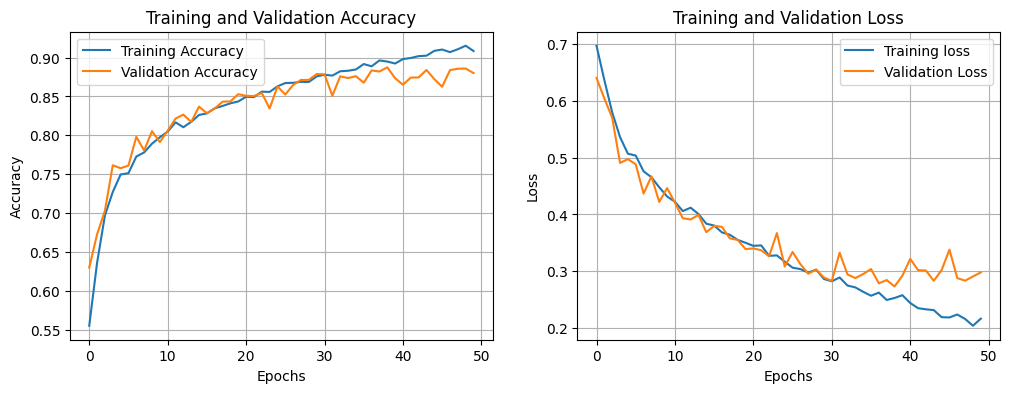

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1,2,2)
plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [27]:
y_pred=model.predict(val_iterator)

In [28]:
y_pred_classes=(y_pred>0.5).astype(int).flatten()
y_true=val_iterator.classes

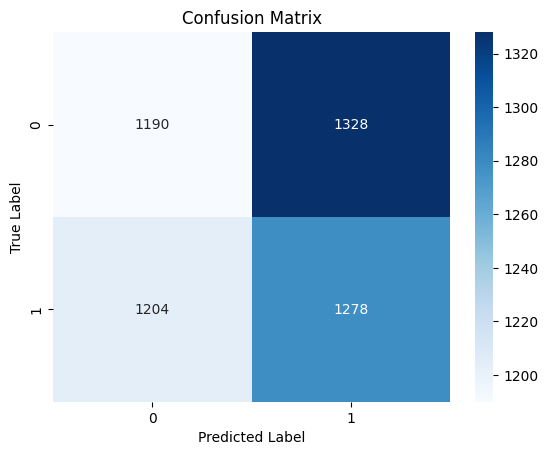

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix=confusion_matrix(y_true,y_pred_classes)
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
print('Classification Report:\n',classification_report(y_true,y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.47      0.48      2518
           1       0.49      0.51      0.50      2482

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000



In [31]:
# at end of your training notebook
model.save("model.h5")    # creates a standalone HDF5 file